In [8]:
import torch
import torch.nn as nn
import pandas as pd
import pickle
import numpy as np
import re
import spacy

from collections import Counter
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import string
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
#from jupyterthemes import jtplot
from pylab import rcParams

In [9]:
#jtplot.style()

In [10]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
#raw_data_path = 'data/evaluation-final.csv'
raw_data_path = 'annotation-final-sorted-filtered.csv'
df = pd.read_csv(raw_data_path)

In [12]:
def clean_text(string):
    output = string.strip()
    # replacements = (("“", '"'), ("”", '"'), ("//", ""), ("«", '"'), ("»",'"'))
    
    # Quitamos símbolos que no aportan información
    replacements = (
        ("“", ' '), ("”", ' '), ("//", " "), ("«", ' '), ("»", ' '), (",", ' '),
        (";", ' '), (".", ' '), ("_", " "), (":", " "), ("x000D", " "), ("!", " "),
        ("¡", " "), ("¿", " "), ("?", " "), ("-", " "), ("…", " "), ('"', ' '),
        ("[", ""), ("]", ""), ("´", " "), ("'", " "), ("–", " "), ("–", " "),
        ("^", " "), ("•", " "), ("—", " "), ("/", " "), ("~", " "), ('#', ' '),
        (">", " "), ("<", " "), (")", " "), ("(", " "), ("%", " "), ("―", " "),
        ("£", " "), ("€", " "), ("|", " "), ("¥", " "), ("·", " "), ('¨', ' '),
         ("°", " "), ("*", " "), ("\\", ''),
    )
    for replacement in replacements:
        output = output.replace(*replacement)
    # Any sequence of two or more spaces should be converted into one space
    #output = re.sub(r'(?is)\s+', ' ', output)
    output = re.sub(r'[0-9]', '', output)  # Quitar números
    output = re.sub(r'\t+', ' ', output)  # Cambiar tabulaciones por espacios
    output = re.sub(r'\n{2,}', '\n', output)  # Cambiar varios saltos de línea seguidos por uno solo
    output = re.sub(r' {2,}', ' ', output)  # Cambiar varios espacios seguidos por uno solo
    output = re.sub(r'^\s+\*.*\n', ' ', output)  # Quitar líneas con * y espacios
    output = re.sub(r'\n\s+\n*', ' ', output)  # Quitar líneas en las que hay únicamente espacios
    output = re.sub(r'\n', ' <CR> ', output)  # Cambiar saltos de línea por etiqueta <CR>
    return output.strip()


def clean_labels(label):
    return "unknown" if str(label) == "None" else label

In [13]:
def encode_sentence(text, vocab2index, N=300):
    tokenized = tokenize(text)
    encoded = np.zeros(N, dtype=int)
    enc1 = np.array([vocab2index.get(word, vocab2index["UNK"]) for word in tokenized])
    length = min(N, len(enc1))
    encoded[:length] = enc1[:length]
    return encoded, length

## Load Dataset

In [14]:
def prepare_data():
    df_out = pd.DataFrame()
    df = (pd
        .read_csv(raw_data_path)
        .rename(columns={"Stanza_text": "text", "ST_Correct": "stanza"})
        .assign(
            text=lambda x: x["text"].apply(clean_text),
            stanza=lambda x: x["stanza"].apply(clean_labels),
        )
    )
    label_encoder = LabelEncoder()
    df_out["text"] = df["text"]
    df_out["label"] = label_encoder.fit_transform(df["stanza"])
    return df_out

In [15]:
df_full = prepare_data()

In [16]:
tok = spacy.load('es_core_news_lg')
def tokenize (text):
    #text = re.sub(r"[^\x00-\x7F]+", " ", text)
    #regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]') # remove punctuation and numbers
    #nopunct = regex.sub(" ", text.lower())
    return [token.text for token in tok.tokenizer(text)]
    
    # Para usar todo el texto en minúsculas, comentar la línea return de arriba y descomentar la siguiente:
    #return [token.lower_ for token in tok.tokenizer(text)]

In [17]:
counts = Counter()
for index, row in df_full.iterrows():
    counts.update(tokenize(row['text']))

In [18]:
vocab2index = {"":0, "UNK":1}
words = ["", "UNK"]
for word in counts:
    vocab2index[word] = len(words)
    words.append(word)

In [19]:
df_full['encoded'] = df_full['text'].apply(lambda x: np.array(encode_sentence(x,vocab2index )))
df_full['length'] = df_full['text'].apply(lambda x: len(x.split()))

<ipython-input-19-25aafb958aff>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  df_full['encoded'] = df_full['text'].apply(lambda x: np.array(encode_sentence(x,vocab2index )))


In [20]:
class StanzasDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.y = Y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx][0], self.y[idx], self.X[idx][1]

In [21]:
train, test = train_test_split(df_full,stratify=df_full["label"], test_size=0.2, random_state=42)
X_test = list(test['encoded'])
y_test = list(test['label'])

In [22]:
X = list(train['encoded'])
y = list(train['label'])
X_train, X_valid, y_train, y_valid = train_test_split(X, y,stratify=train["label"], test_size=0.2, random_state=42)

In [23]:
train_ds = StanzasDataset(X_train, y_train)
valid_ds = StanzasDataset(X_valid, y_valid)
test_ds = StanzasDataset(X_test, y_test)

## Embeddings

### Bajar el archivo SBW-vectors-300-min5.txt.zip de kaggle y descomprimir:
https://www.kaggle.com/rtatman/pretrained-word-vectors-for-spanish

In [24]:
def load_glove_vectors(glove_file="SBW-vectors-300-min5.txt"):
    """Load the glove word vectors"""
    word_vectors = {}
    with open(glove_file) as f:
        for line in f:
            split = line.split()
            word_vectors[split[0]] = np.array([float(x) for x in split[1:]])
    return word_vectors

In [25]:
def get_emb_matrix(pretrained, word_counts, emb_size = 300):
    """ Creates embedding matrix from word vectors"""
    oov_words = []
    vocab_size = len(word_counts) + 2
    vocab_to_idx = {}
    vocab = ["", "UNK"]
    W = np.zeros((vocab_size, emb_size), dtype="float32")
    W[0] = np.zeros(emb_size, dtype='float32') # adding a vector for padding
    W[1] = np.random.uniform(-0.25, 0.25, emb_size) # adding a vector for unknown words 
    vocab_to_idx["UNK"] = 1
    i = 2
    for word in word_counts:
        if word in word_vecs:
            W[i] = word_vecs[word]
        else:
            W[i] = np.random.uniform(-0.25,0.25, emb_size)
            oov_words.append(word)
        vocab_to_idx[word] = i
        vocab.append(word)
        i += 1   
    return W, np.array(vocab), vocab_to_idx, oov_words

In [26]:
word_vecs = load_glove_vectors()

In [27]:
pretrained_weights, vocab, vocab2index, oov_words = get_emb_matrix(word_vecs, counts)

### Porcentaje de palabras fuera del vocabulario:

In [28]:
len(oov_words) * 100 / len(vocab)

12.597119729527648

In [30]:
## Descomentar para usar pesos preentrenados
# pretrained_weights = pickle.load(open("glove_weights_verses","rb"))

# Training

In [38]:
def train_model(model, epochs=10, lr=0.001):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.AdamW(parameters, lr=lr)
    train_losses = []
    valid_losses = []    
    for i in range(epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        for x, y, l in train_dl:
            x = x.long()
            y = y.long()
            x = x.cuda()
            y = y.cuda()
            y_pred = model(x, l.cpu())
            optimizer.zero_grad()
            loss = F.cross_entropy(y_pred, y)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()*y.shape[0]
            total += y.shape[0]
        #val_loss, val_acc, val_rmse = validation_metrics(model, val_dl)
        val_loss, val_acc, _ = validation_metrics(model, val_dl)
        
        train_losses.append(sum_loss/total)
        valid_losses.append(val_loss)
        if i % 5 == 9999999: #1:
            #print(i, "train loss %.3f, val loss %.3f, val accuracy %.3f, and val rmse %.3f" % (sum_loss/total, val_loss, val_acc, val_rmse))
            print("train loss %.3f, val loss %.3f, val accuracy %.3f" % (sum_loss/total, val_loss, val_acc))
        
    test_acc = test_model(model, test_dl)
    print("test accuracy %.3f" % (test_acc))
    if PRINT_PLOT:
        #Print plot
        rcParams['figure.figsize'] = 20, 10
        plt.plot(range(1,len(train_losses)+1), train_losses, label='Train')
        plt.plot(range(1,len(valid_losses)+1), valid_losses, label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        leg = plt.legend();

def validation_metrics (model, valid_dl):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    sum_rmse = 0.0
    for x, y, l in valid_dl:
        x = x.long()
        y = y.long()
        x = x.cuda()
        y = y.cuda()
        y_hat = model(x, l.cpu())
        loss = F.cross_entropy(y_hat, y)
        pred = torch.max(y_hat, 1)[1]
        correct += (pred == y).float().sum()
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
        #sum_rmse += np.sqrt(mean_squared_error(pred, y.unsqueeze(-1)))*y.shape[0]
    return sum_loss/total, correct/total, sum_rmse/total

def test_model(model, test_dl):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    sum_rmse = 0.0
    for x, y, l in test_dl:
        x = x.long()
        y = y.long()
        x = x.cuda()
        y = y.cuda()
        y_hat = model(x, l.cpu())
        pred = torch.max(y_hat, 1)[1]
        correct += (pred == y).float().sum()
        total += y.shape[0]
    return correct/total

In [39]:
# 1. Añadir información de número de versos en los embedings
# 2. Añadir info de patrón métrico
class BiLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, glove_weights) :
        super().__init__()
        self.hidden_dim = hidden_dim
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.embeddings.weight.data.copy_(torch.from_numpy(glove_weights))
        self.embeddings.weight.requires_grad = False ## False freezes embeddings
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, num_layers=3, dropout=0.2, bidirectional=True)
        self.linear = nn.Linear(hidden_dim, 46)
        
    def forward(self, text, text_length):
        x = self.embeddings(text)
        x_pack = pack_padded_sequence(x, text_length, batch_first=True, enforce_sorted=False)
        out_pack, (ht, ct) = self.lstm(x_pack)
        out = self.linear(ht[-1])
        return out

In [40]:
batch_size = 1024
vocab_size = len(words)
train_dl = DataLoader(train_ds, batch_size=batch_size)#, shuffle=True)
val_dl = DataLoader(valid_ds, batch_size=batch_size)
test_dl = DataLoader(test_ds)

In [41]:
model = BiLSTM(vocab_size, 300, 300, pretrained_weights)
model = model.cuda()

test accuracy 0.665


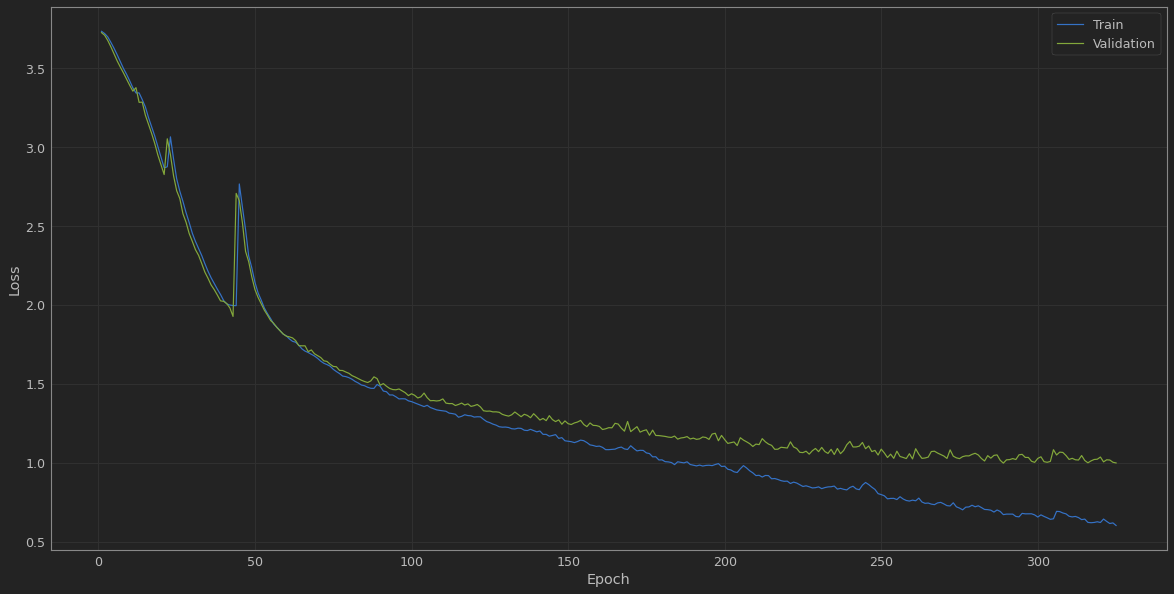

In [43]:
PRINT_PLOT = True
train_model(model, epochs=325, lr=0.000125)

## Entrenar el modelo 10 veces para calcular la media

In [463]:
PRINT_PLOT = False

In [464]:
for i in range(0,10):
    model = BiLSTM(vocab_size, 300, 300, pretrained_weights)
    model = model.cuda()
    train_model(model, epochs=325, lr=0.000125)

test accuracy 0.642
test accuracy 0.670
test accuracy 0.650
test accuracy 0.662
test accuracy 0.656
test accuracy 0.664
test accuracy 0.596
test accuracy 0.659
test accuracy 0.650


KeyboardInterrupt: 